In [43]:
% matplotlib inline

import pandas as pd, numpy as np
import seaborn as sns
import utils.stats as stats
import utils.viz as viz
import statsmodels.formula.api as smf
import utils.viz as viz
from scipy.stats import shapiro
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('poster')

## Structural connectivity distance

In [44]:
data_dir = '/Users/sabine/workspace/distconnect_macaque/data'

df = pd.read_pickle('%s/df_regionwise.pkl' % data_dir)

In [45]:
df = df_r.rename(columns={'injection distance from nearest primary region': "dist_inj_prim",
                          'incoming': "connectivity_distance"})


## Exclusion of anteriormost PFC 
### Regions that lie further from primary cortex than anyother region in the cortex

In [46]:
# exclusions as defned by max distance from primary (see func analysis) 
excl_areas = ['10', '11', '13', '14', '24c', '25', '32', '46d', '46v', '9', 'F6', 'OPAI']

fltr = df_r.area.isin(excl_areas)
fltr = (df_r.area.isin(excl_areas) | df_r.connectivity_distance.isnull())

In [47]:
df['inclusion'] = (~df_r.area.isin(excl_areas) & df_r.connectivity_distance.notnull())

# STATS
## Relationship of connectivity distance with distance from primary cortex

In [48]:
model = smf.ols(formula='connectivity_distance ~ location \
                                                 + region_size \
                                                 + dist_inj_prim', data=df[df.inclusion==True]).fit()
print model.summary()

                              OLS Regression Results                             
Dep. Variable:     connectivity_distance   R-squared:                       0.543
Model:                               OLS   Adj. R-squared:                  0.481
Method:                    Least Squares   F-statistic:                     8.718
Date:                   Thu, 04 Oct 2018   Prob (F-statistic):           0.000534
Time:                           23:21:48   Log-Likelihood:                -65.757
No. Observations:                     26   AIC:                             139.5
Df Residuals:                         22   BIC:                             144.5
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       

In [49]:
df.loc[df.inclusion==True, 'struct_resid'] = model.resid
df.loc[df.inclusion==True, 'struct_stud_resid'] = model.outlier_test()['student_resid']
df.loc[df.inclusion==True, 'struct_unadj_p'] = model.outlier_test()['unadj_p']
df.loc[df.inclusion==True, 'struct_bonf_p'] = model.outlier_test()['bonf(p)']

In [50]:
cols = ['area', 'dist_inj_prim', 'connectivity_distance', 
        'struct_resid', 'struct_stud_resid', 'struct_unadj_p', 'struct_bonf_p']

In [51]:
df.loc[df.inclusion==True, cols].sort_values(by='struct_stud_resid').head()

,area,dist_inj_prim,connectivity_distance,struct_resid,struct_stud_resid,struct_unadj_p,struct_bonf_p
21,TEpd,27.890625,14.170338,-7.990284,-3.344438,0.003073,0.079908
65,8B,22.500000,13.575339,-3.148467,-1.055353,0.303255,1.000000
45,7B,12.906250,16.025179,-2.930100,-0.945203,0.355305,1.000000
10,STPc,10.773438,15.879031,-2.969877,-0.943693,0.356058,1.000000
34,V1,0.000000,25.740364,-1.869369,-0.829785,0.415994,1.000000


In [52]:
df.loc[df.inclusion==True, cols].sort_values(by='struct_stud_resid').tail()

,area,dist_inj_prim,connectivity_distance,struct_resid,struct_stud_resid,struct_unadj_p,struct_bonf_p
42,9_46d,19.812500,17.711961,2.224252,0.737985,0.468691,1.000000
7,DP,22.078125,24.766858,3.547299,1.200520,0.243305,1.000000
44,9_46v,26.453125,20.402974,3.563454,1.256535,0.222720,1.000000
47,5,10.250000,26.805691,5.483681,1.827052,0.081940,1.000000
39,7A,19.093750,28.055723,6.710558,2.440189,0.023631,0.614411


## Connectivity distance (corrected)

In [53]:
null = smf.ols(formula='connectivity_distance ~  location \
                                                 + region_size', data=df[df.inclusion==True]).fit()

# for plotting
df.loc[df.inclusion==True, 'corrected_condist'] = null.resid + df.connectivity_distance[df.inclusion==True].mean()

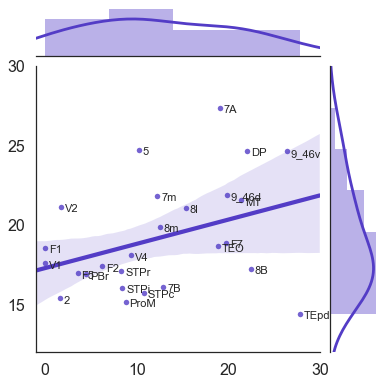

In [54]:
sns.set_style('white')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.4, point['y']-.3, str(point['val']), size='xx-small')


g = sns.jointplot(x="dist_inj_prim", 
                  y="corrected_condist", 
                  data=df[df.inclusion==True], 
                  kind='reg', 
                  color="#533cc6", 
                  xlim=(-2,30), 
                  ylim=(13,27),
                  stat_func=None,
                  scatter_kws={"s": 30})


plt.xticks([0,10,20,30])
#plt.yticks([0,10,20,30])
plt.xlim(-1,30)
#plt.xticks([0,5,15,25])
plt.ylim(12,30)
plt.yticks([15, 20, 25, 30])

plt.xlabel('')
plt.ylabel('')


label_point(df.dist_inj_prim[df.inclusion==True], 
            df.corrected_condist[df.inclusion==True], 
            df.area[df.inclusion==True], 
            plt.gca()) 


#g.savefig('/Users/sabine/Downloads/relationship_struct.png', dpi=300)

In [55]:
excl_areas_2 = ['10', '11', '13', '14', 
                '24c', '25', '32', '46d', '46v', 
                '9', 'F6', 'OPAI']#, 'TEpd'] 
fltr_2 = (df.area.isin(excl_areas_2) | df.connectivity_distance.isnull())

#labels_TEpd = [np.array(df_r[df_r.area=='TEpd'].vertices.iloc[0]),] # remove


labels_pfc = list()
for area in excl_areas_2[:-1]:
    labels_pfc += list(np.array(df[df.area==area].vertices.iloc[0]))
    
labels_pfc = [np.array(labels_pfc),]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


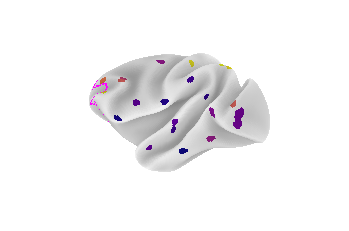

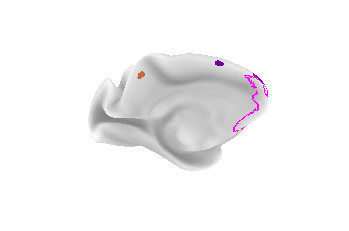

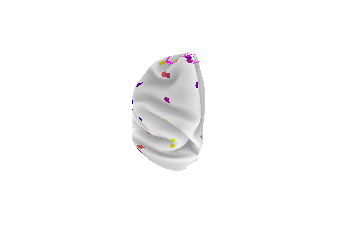

In [56]:
viz.plot_inj_yerkes(df, 'corrected_condist', 
                    vmin=15, vmax=25, cmap='plasma', surftype='inflated',
                    views=[(180,0), (0,0), (270,90)],
                    labels=labels_pfc,#+labels_TEpd,
                    label_cpal=['magenta'])#,#, 'grass green'],
                    #f_save='/Users/sabine/Downloads/struct_condist')

## Connectivity distance (raw)

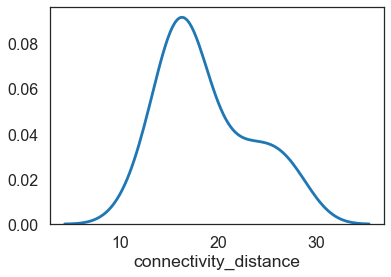

In [57]:
sns.distplot(df.connectivity_distance[~df.connectivity_distance.isnull()], hist=False)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


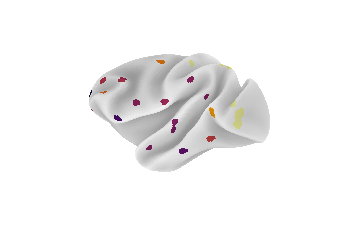

In [9]:
viz.plot_inj_yerkes(df, 'connectivity_distance', vmin=10, vmax=25)

In [58]:
df.to_pickle('./data/df_struct.pkl') # for combining with struct later